In [83]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [32]:
#initializing model yolo
model = YOLO('yolov8s.pt')

In [ ]:
results = model.train(data='data.yaml', epochs=50, batch =-1, imgsz=640)

In [68]:
i=0
model = YOLO('runs/detect/train8/weights/best.pt')
results = model(['test_images/16.jpg'])
for result in results:
    boxes = result.boxes
    masks = result.masks
    keypoints = result.keypoints
    probs = result.probs
    result.show()
    result.save(filename=f'result{i}.jpg')
    i+=1


0: 640x480 2 Carrots, 1 Cheese, 1 LazagnaPasta, 2 Onions, 37.0ms
Speed: 4.0ms preprocess, 37.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


In [35]:
models = [
    ('SVM rbf', SVC(), {'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 5], 'C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}),
    ('SVM poly', SVC(), {'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5, 6], 'C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}),
    ('KNN', KNeighborsClassifier(), {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}),
    ('Random Forest', RandomForestClassifier(), {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [3, 5, 10, 15]}),
    ('Decision Tree', DecisionTreeClassifier(), {'criterion':['entropy', 'gini'], 'max_depth': [3, 5, 10, 15]})
]

In [73]:
#Data
df = pd.read_csv('recipe_variations.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(['RecipeName'], axis=1), df['RecipeName'], test_size=0.3, random_state=42)

In [74]:
X_train.isna().sum()
X_train = np.array(X_train)
X_test = np.array(X_test)

In [36]:
#Grid Search
for name, model, params in models:
    grid = GridSearchCV(model, params, cv=5)
    grid.fit(X_train, y_train)
    print(f'{name}: Best parameters={grid.best_params_}, Best score={grid.best_score_}')

SVM rbf: Best parameters={'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, Best score=1.0
SVM poly: Best parameters={'C': 10, 'degree': 1, 'kernel': 'poly'}, Best score=0.9985714285714286
KNN: Best parameters={'n_neighbors': 9}, Best score=0.9842857142857143
Random Forest: Best parameters={'max_depth': 3, 'n_estimators': 20}, Best score=1.0
Decision Tree: Best parameters={'criterion': 'entropy', 'max_depth': 5}, Best score=1.0


In [75]:
svm_rbf = SVC(kernel='rbf', gamma=0.01, C=10).fit(X_train, y_train)
svm_poly = SVC(kernel='poly', degree=1, C=10).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
rfc = RandomForestClassifier(n_estimators=20, max_depth=3).fit(X_train, y_train)
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(X_train, y_train)

In [59]:
y_pred1 = svm_rbf.predict(X_test)
y_pred2 = svm_poly.predict(X_test)
y_pred3 = knn.predict(X_test)
y_pred4 = rfc.predict(X_test)
y_pred5 = dtc.predict(X_test)
y_pred = [(y_pred1, 'svm_rbf'), (y_pred2, 'svm_poly'), (y_pred3, 'knn'), (y_pred4, 'rfc'), (y_pred5, 'dtc')]

In [39]:
for y, name in y_pred:
    print(f"{name}::")
    mae = mean_absolute_error(y_test, y)
    print(f"Mean Absolute Error: {mae}")
    mse = mean_squared_error(y_test, y)
    print(f"Mean Squared Error: {mse}")
    rmse = mean_squared_error(y_test, y, squared=False)
    print(f"Root Mean Squared Error: {rmse}")
    r2 = r2_score(y_test, y)
    print(f"R2 score: {r2}")
    accs = accuracy_score(y_test, y)
    print(f"accuracy_score: {accs}")
    print("    ")

svm_rbf::
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
R2 score: 1.0
accuracy_score: 1.0
    
svm_poly::
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
R2 score: 1.0
accuracy_score: 1.0
    
knn::
Mean Absolute Error: 0.18333333333333332
Mean Squared Error: 1.5966666666666667
Root Mean Squared Error: 1.2635927614016578
R2 score: 0.9528478178908569
accuracy_score: 0.9733333333333334
    
rfc::
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
R2 score: 1.0
accuracy_score: 1.0
    
dtc::
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
R2 score: 1.0
accuracy_score: 1.0
    


In [79]:
for y, name in y_pred:
    print(f"{name}::")
    print(f"Classification Report: {classification_report(y_test, y)}")
    cm = confusion_matrix(y_test, y)
    print(f"Confusion Matrix: {cm}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print("    ")

svm_rbf::
Classification Report:                        precision    recall  f1-score   support

            Bean Soup       1.00      1.00      1.00        15
             Beef Pie       1.00      1.00      1.00        14
        Beef Sandwich       1.00      1.00      1.00        19
      Beef Stroganoff       1.00      1.00      1.00        15
           Beshbarmak       1.00      1.00      1.00        12
         Carrot Salad       1.00      1.00      1.00        11
       Cheese Lasagna       1.00      1.00      1.00        16
      Chicken Alfredo       1.00      1.00      1.00        20
         Chicken Soup       1.00      1.00      1.00        17
      Classic Lasagna       1.00      1.00      1.00        10
           Fried Rice       1.00      1.00      1.00        20
Garlic Rosted Chicken       1.00      1.00      1.00        16
              Kuyrdak       1.00      1.00      1.00        13
      Mashed Potatoes       1.00      1.00      1.00        13
             Omelette

In [77]:
joblib.dump(rfc, "./class.joblib")

['./class.joblib']

<Figure size 1500x1500 with 0 Axes>

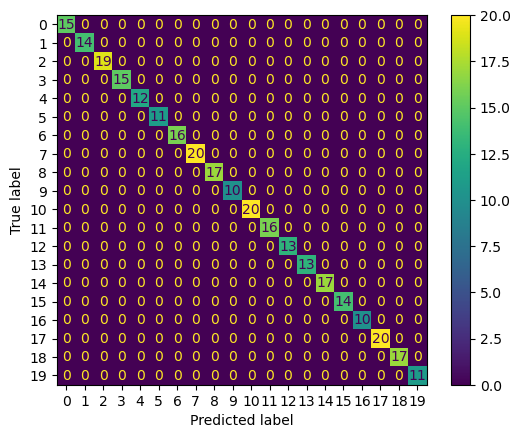

In [88]:
cm1 = confusion_matrix(y_test, y_pred5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(15,15))
disp.plot()
plt.show()